# Importing Data

In [173]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

%matplotlib inline

In [174]:
jan_2018 = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv', dtype = 'unicode')

In [175]:
feb_2018 = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_2.csv', dtype = 'unicode')

In [176]:
mar_2018 = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_3.csv', dtype = 'unicode')

In [177]:
jul_2018 = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_7.csv', dtype = 'unicode')

In [178]:
aug_2018 = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_8.csv', dtype = 'unicode')

In [179]:
sep_2018 = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv', dtype = 'unicode')

In [180]:
df = pd.concat([jan_2018, feb_2018, mar_2018, jul_2018, aug_2018, sep_2018])

In [181]:
df_winter2018 = pd.concat([jan_2018, feb_2018, mar_2018])

In [182]:
df_summer2018 = pd.concat([jul_2018, aug_2018, sep_2018])

# Optimising Data

In [183]:
# Fill NaN value with 0

df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0)
df['ArrDelayMinutes'] = df['ArrDelayMinutes'].fillna(0)
df['WeatherDelay'] = df['WeatherDelay'].fillna(0)
df_winter2018['WeatherDelay'] = df_winter2018['WeatherDelay'].fillna(0)
df_summer2018['WeatherDelay'] = df_summer2018['WeatherDelay'].fillna(0)

In [184]:
#convert just column 'Departure Delay Minutes' to numeric

df['ArrDelayMinutes'] = pd.to_numeric(df['ArrDelayMinutes'])
df['DepDelayMinutes'] = pd.to_numeric(df['DepDelayMinutes'])
df['WeatherDelay'] = pd.to_numeric(df['WeatherDelay'])
df['NASDelay'] = pd.to_numeric(df['NASDelay'])
df['SecurityDelay'] = pd.to_numeric(df['SecurityDelay'])
df['LateAircraftDelay'] = pd.to_numeric(df['LateAircraftDelay'])
df['CarrierDelay'] = pd.to_numeric(df['CarrierDelay'])
df['DepTime'] = pd.to_numeric(df['DepTime'])
df['CRSDepTime'] = pd.to_numeric(df['CRSDepTime'])
df['TaxiOut'] = pd.to_numeric(df['TaxiOut'])
df['TaxiIn'] = pd.to_numeric(df['TaxiIn'])
df_winter2018['TaxiOut'] = pd.to_numeric(df_winter2018['TaxiOut'])
df_winter2018['TaxiIn'] = pd.to_numeric(df_winter2018['TaxiIn'])
df_summer2018['TaxiOut'] = pd.to_numeric(df_summer2018['TaxiOut'])
df_summer2018['TaxiIn'] = pd.to_numeric(df_summer2018['TaxiIn'])
df_winter2018['WeatherDelay'] = pd.to_numeric(df_winter2018['WeatherDelay'])
df_summer2018['WeatherDelay'] = pd.to_numeric(df_summer2018['WeatherDelay'])

# Convert to Date

df['FlightDate'] = pd.to_datetime(df['FlightDate'])


# Southwest (WN)

Extreme delays (> 60 minutes) are removed to avoid bias.

Considering 2 scenarios: (a) Take all initial values (b) Remove all extreme values 

In [185]:
wn_df = df[df['Reporting_Airline'] == 'WN']

### Departure Block Time

In [186]:
# Splitting extreme delays and original

wn_df_filtered = wn_df[wn_df['DepDelayMinutes'] < 60]

average_delay_per_time_block_filtered = wn_df_filtered.groupby('DepTimeBlk')['DepDelayMinutes'].mean()
average_delay_per_time_block_all = wn_df.groupby('DepTimeBlk')['DepDelayMinutes'].mean()

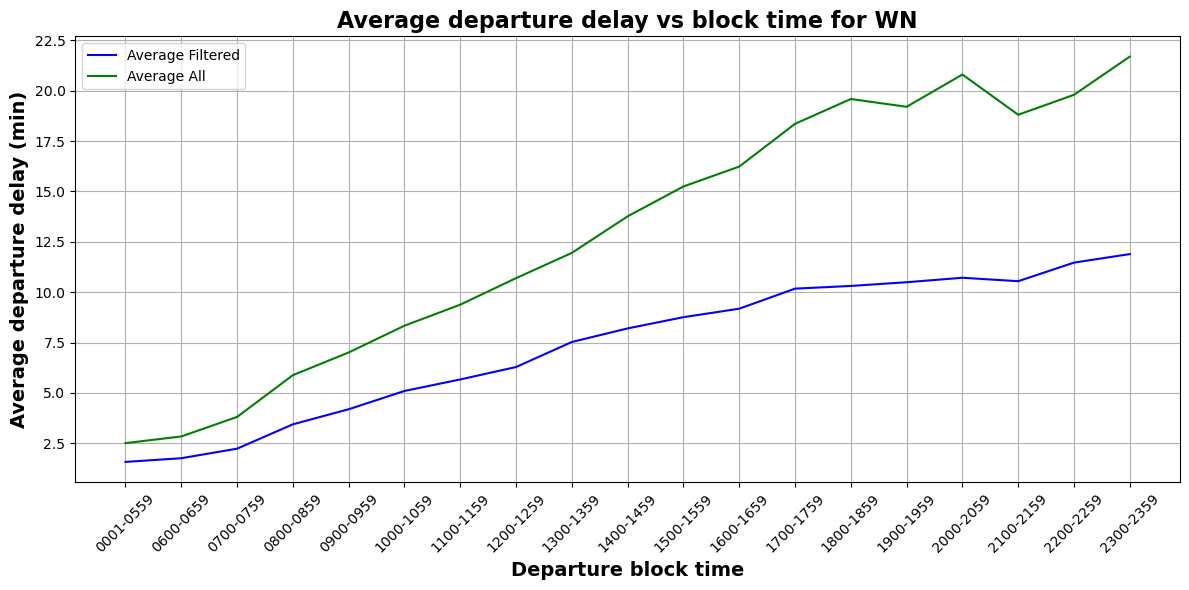

In [187]:
# Sort the index of the average_delay_per_time_block_filtered DataFrame
average_delay_per_time_block_filtered = average_delay_per_time_block_filtered.sort_index()

# Sort the index of the average_delay_per_time_block_all DataFrame
average_delay_per_time_block_all = average_delay_per_time_block_all.sort_index()

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the average DepDelayMinutes for filtered data
plt.plot(average_delay_per_time_block_filtered.index, 
         average_delay_per_time_block_filtered.values, 
         color='blue', 
         label='Average Filtered'
        )

# Plot the average DepDelayMinutes for all data
plt.plot(average_delay_per_time_block_all.index, 
         average_delay_per_time_block_all.values, 
         color='green', 
         label='Average All'
        )

plt.xlabel('Departure block time', fontsize=14, weight='bold')
plt.ylabel('Average departure delay (min)', fontsize=14, weight='bold')
plt.title('Average departure delay vs block time for WN', fontsize=16, weight='bold')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('DepDelayvsBlkTime.png', format='png', dpi=300)


### Predicted vs. Observed - WN

In [188]:
# Defining variables
features = ['ArrDelayMinutes', 'Origin']
X = wn_df[features]
y = wn_df['DepDelayMinutes']

# Define the column transformer to handle one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), ['Origin'])], 
    remainder='passthrough'
)

# Initialize and train the linear regression model with preprocessing
model = LinearRegression()
model.fit(preprocessor.fit_transform(X), y)

# Use the trained model to predict DepDelayMinutes for each data point
wn_df['Predicted_Delay'] = model.predict(preprocessor.transform(X))
wn_df['Predicted_Delay'] = wn_df['Predicted_Delay']  # Using .loc to set values explicitly

/var/folders/34/1d5cw2sd1g72r24h9_zrrfyh0000gn/T/ipykernel_15893/2617098678.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wn_df['Predicted_Delay'] = model.predict(preprocessor.transform(X))
/var/folders/34/1d5cw2sd1g72r24h9_zrrfyh0000gn/T/ipykernel_15893/2617098678.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wn_df['Predicted_Delay'] = wn_df['Predicted_Delay']  # Using .loc to set values explicitly


/var/folders/34/1d5cw2sd1g72r24h9_zrrfyh0000gn/T/ipykernel_15893/408537492.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sorted_data = wn_df.groupby('Origin').mean().sort_values(by='Predicted_Delay')


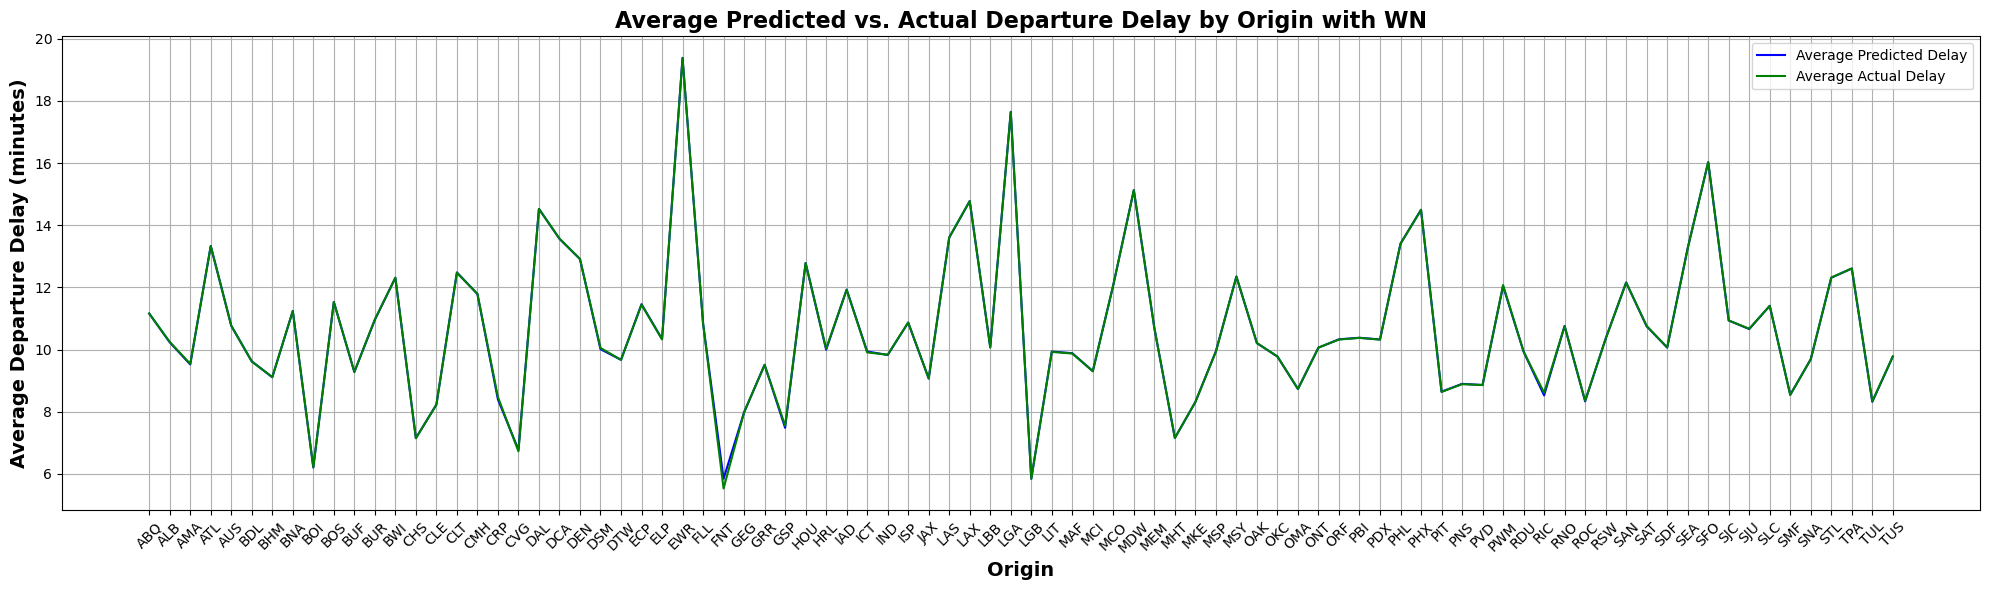

In [189]:
# Group the data by 'Origin' and calculate the average actual and predicted delay
average_actual_delay = wn_df.groupby('Origin')['DepDelayMinutes'].mean()
average_predicted_delay = wn_df.groupby('Origin')['Predicted_Delay'].mean()

# Sort the data by average predicted delay (optional)
sorted_data = wn_df.groupby('Origin').mean().sort_values(by='Predicted_Delay')

# Sort the data by Origin in alphabetical order
sorted_data = sorted_data.reindex(sorted_data.index.sort_values())

# Plot the results
plt.figure(figsize=(20, 6))

plt.plot(sorted_data.index, sorted_data['Predicted_Delay'], color='blue', label='Average Predicted Delay')
plt.plot(sorted_data.index, sorted_data['DepDelayMinutes'], color='green', label='Average Actual Delay')

plt.xlabel('Origin', fontsize=14, weight='bold')
plt.ylabel('Average Departure Delay (minutes)', fontsize=14, weight='bold')
plt.title('Average Predicted vs. Actual Departure Delay by Origin with WN', fontsize=16, weight='bold')

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Predicted_ObservedWN_Sorted.png', format='png', dpi=300)

In [190]:
# Calculating MSE
y_true = wn_df['DepDelayMinutes']
y_pred = wn_df['Predicted_Delay']

mse = mean_squared_error(y_true, y_pred)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 72.76123376626433


### United Airlines (UA)

In [191]:
ua_df = df[df['Reporting_Airline'] == 'UA']

In [192]:
# Splitting extreme delays and original

ua_df_filtered = ua_df[ua_df['DepDelayMinutes'] < 60]

average_delay_per_time_block_filtered_ua = ua_df_filtered.groupby('DepTimeBlk')['DepDelayMinutes'].mean()
average_delay_per_time_block_all_ua = ua_df.groupby('DepTimeBlk')['DepDelayMinutes'].mean()

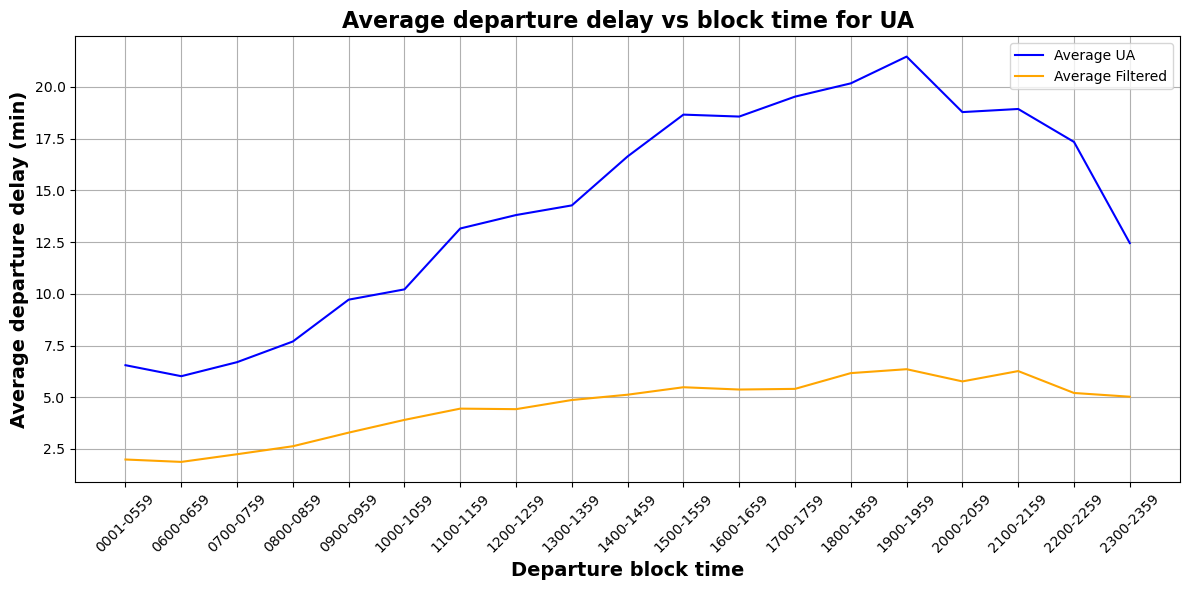

In [193]:
# Assuming you have a DataFrame named wn_df

# Filter the DataFrame for flights from UA
ua_df = ua_df[ua_df['Reporting_Airline'] == 'UA']

# Group the data by 'DepTimeBlk' and calculate the average observed DepDelayMinutes
average_delay_per_time_block_ua = ua_df.groupby('DepTimeBlk')['DepDelayMinutes'].mean()

# Sort the index of the DataFrame
average_delay_per_time_block_ua = average_delay_per_time_block_ua.sort_index()

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the average DepDelayMinutes for UA
plt.plot(average_delay_per_time_block_ua.index, 
         average_delay_per_time_block_ua.values, 
         color='blue', 
         label='Average UA'
        )

# Plot the average DepDelayMinutes for filtered data
plt.plot(average_delay_per_time_block_filtered_ua.index, 
         average_delay_per_time_block_filtered_ua.values, 
         color='orange', 
         label='Average Filtered'
        )

plt.xlabel('Departure block time', fontsize=14, weight='bold')
plt.ylabel('Average departure delay (min)', fontsize=14, weight='bold')
plt.title('Average departure delay vs block time for UA', fontsize=16, weight='bold')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('DepDelayvsBlkTime_UA.png', format='png', dpi=300)


### Predicted vs. Observed - UA

In [194]:
# Defining variables
features = ['ArrDelayMinutes', 'Origin']
X = ua_df[features]
y = ua_df['DepDelayMinutes']

# Define the column transformer to handle one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), ['Origin'])], 
    remainder='passthrough'
)

# Initialize and train the linear regression model with preprocessing
model = LinearRegression()
model.fit(preprocessor.fit_transform(X), y)

# Use the trained model to predict DepDelayMinutes for each data point
ua_df['Predicted_Delay'] = model.predict(preprocessor.transform(X))
ua_df['Predicted_Delay'] = ua_df['Predicted_Delay']  # Using .loc to set values explicitly

/var/folders/34/1d5cw2sd1g72r24h9_zrrfyh0000gn/T/ipykernel_15893/1730639711.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sorted_data = ua_df.groupby('Origin').mean().sort_values(by='Predicted_Delay')


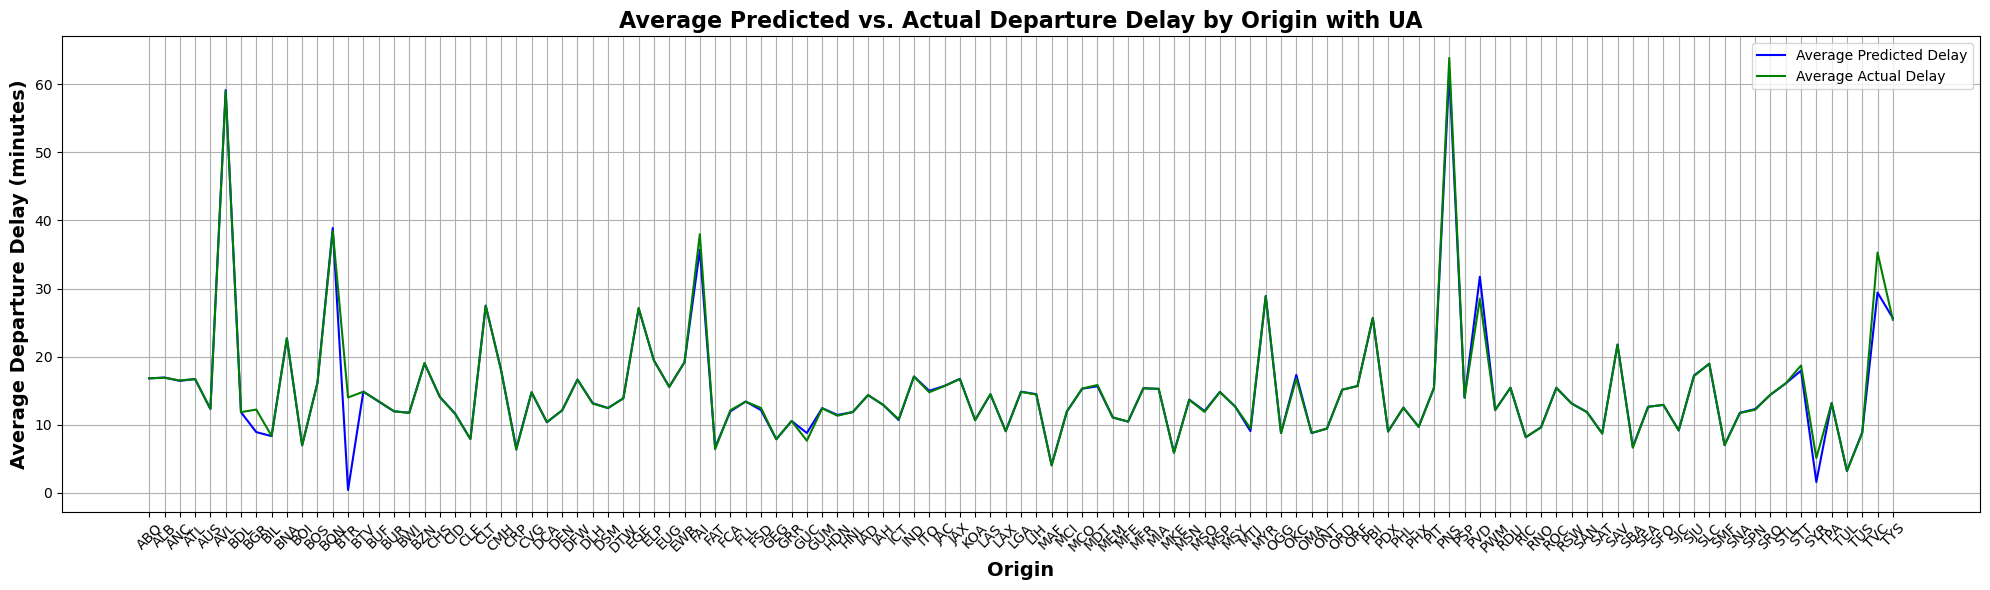

In [195]:
# Group the data by 'Origin' and calculate the average actual and predicted delay
average_actual_delay_ua = ua_df.groupby('Origin')['DepDelayMinutes'].mean()
average_predicted_delay_ua = ua_df.groupby('Origin')['Predicted_Delay'].mean()

# Sort the data by average predicted delay (optional)
sorted_data = ua_df.groupby('Origin').mean().sort_values(by='Predicted_Delay')

# Sort the data by Origin in alphabetical order
sorted_data = sorted_data.reindex(sorted_data.index.sort_values())

# Plot the results
plt.figure(figsize=(20, 6))

plt.plot(sorted_data.index, sorted_data['Predicted_Delay'], color='blue', label='Average Predicted Delay')
plt.plot(sorted_data.index, sorted_data['DepDelayMinutes'], color='green', label='Average Actual Delay')

plt.xlabel('Origin', fontsize=14, weight='bold')
plt.ylabel('Average Departure Delay (minutes)', fontsize=14, weight='bold')
plt.title('Average Predicted vs. Actual Departure Delay by Origin with UA', fontsize=16, weight='bold')

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Predicted_ObservedUA_Sorted.png', format='png', dpi=300)

In [196]:
# Calculating MSE
y_true = ua_df['DepDelayMinutes']
y_pred = ua_df['Predicted_Delay']

mse = mean_squared_error(y_true, y_pred)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 137.89748792204514


# On time arrival prediction

In [197]:
# Defining threshold
threshold = 15

# Target variables
X = df[['Month', 'DayOfWeek', 'CRSDepTime']]
y = (df['ArrDelayMinutes'] <= threshold).astype(int)

In [198]:
# Splitting data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [199]:
model = LogisticRegression()  # Initialize the model
model.fit(X_train, y_train)  # Train the model

LogisticRegression()

In [200]:
# Predict on time arrival

y_pred = model.predict(X_test)

In [201]:
# Generating report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)

/Users/dylanchua/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8184674841276938
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    129925
           1       0.82      1.00      0.90    585787

    accuracy                           0.82    715712
   macro avg       0.41      0.50      0.45    715712
weighted avg       0.67      0.82      0.74    715712

Confusion Matrix:
 [[     0 129925]
 [     0 585787]]


/Users/dylanchua/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylanchua/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


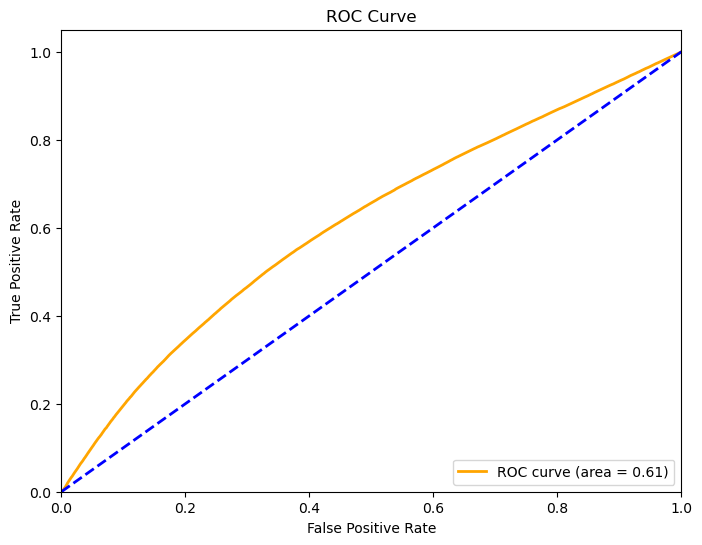

In [202]:
# Calculate the probabilities for on time arrivals
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)

# Create ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('ROCCurve.png', format = "png", dpi = 300)

#### Modelling data

In [203]:
# Train the model
model = RandomForestClassifier(random_state=13, n_estimators=100)
model.fit(X, y)

RandomForestClassifier(random_state=13)

In [207]:
# Defining threshold
threshold = 15

# Variables and features
X = df[['Month', 'DayOfWeek', 'CRSDepTime']]
y = (df['ArrDelayMinutes'] <= threshold).astype(int)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [208]:
# Train a Random Forest classifier
model = RandomForestClassifier(random_state=13, n_estimators=100)
model.fit(X_train, y_train)

# Predict probabilities for on-time arrival
predicted_probabilities = model.predict_proba(X_test)[:, 1]

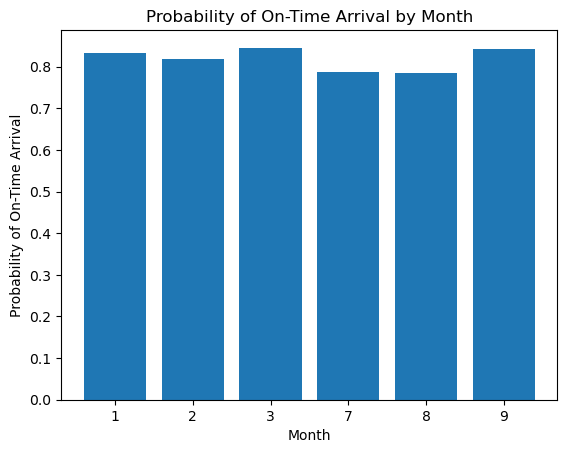

In [209]:
# Plotting the chart
plt.bar(df['Month'].unique(), [predicted_probabilities[X_test['Month'] == month].mean() for month in df['Month'].unique()])
plt.xlabel('Month')
plt.ylabel('Probability of On-Time Arrival')
plt.title('Probability of On-Time Arrival by Month')
plt.savefig('Probability_OTA.png', format = "png", dpi = 300)

# Delay groups

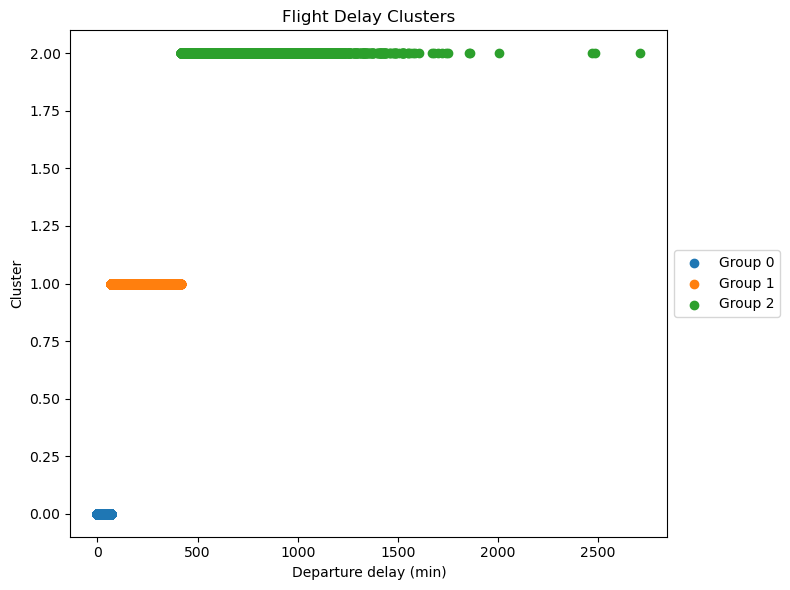

In [210]:
X = df[['DepDelayMinutes']].values

# Number of clusters
num_clusters = 3

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters = num_clusters, random_state = 0, n_init = 10)
kmeans.fit(X)

# Add a new column to your DataFrame with the cluster labels
df['DelayGroup'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize = (8, 6))
for cluster in range(num_clusters):
    plt.scatter(df[df['DelayGroup'] == cluster]['DepDelayMinutes'],
                [cluster] * len(df[df['DelayGroup'] == cluster]),
                label = f'Group {cluster}')

plt.title('Flight Delay Clusters')
plt.xlabel('Departure delay (min)')
plt.ylabel('Cluster')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.tight_layout()
plt.savefig('DelayCluster.png', format = "png", dpi = 300)

# Departure delay

In [211]:
X = df[['Reporting_Airline', 'Origin']]
y = df['DepDelayMinutes']

# Categorical 
X = pd.get_dummies(X, columns = ['Reporting_Airline', 'Origin'], drop_first = True)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [212]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 1934.41499414073
R-squared: 0.005698913095778302


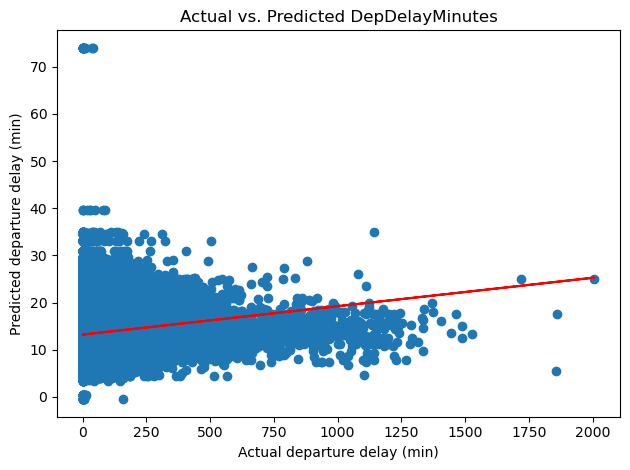

In [213]:
# Plot the predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual departure delay (min)')
plt.ylabel('Predicted departure delay (min)')
plt.title('Actual vs. Predicted DepDelayMinutes')


# Add the regression line
regression_line = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, np.polyval(regression_line, y_test), color='red')
plt.tight_layout()
plt.savefig('DelayCluster.png', format = "png", dpi = 300)

In [214]:
# K-Means cluster of predicted delay
num_clusters = 3
X = df[['DepDelayMinutes']].values
kmeans = KMeans(n_clusters = num_clusters, random_state = 0, n_init = 10)
kmeans.fit(X)
df['Cluster'] = kmeans.labels_

In [215]:
# Training a Linear Regression model
X_train = df[['Cluster']]
y_train = df['DepDelayMinutes']
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [216]:
# Predict and plot onto the cluster chart
predicted_delay = model.predict(df[['Cluster']])

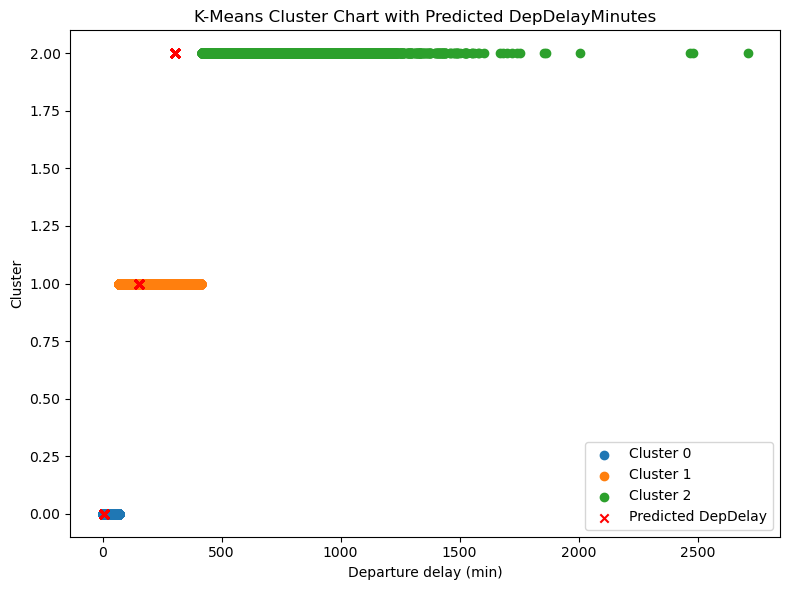

In [217]:
# Create the cluster chart
plt.figure(figsize = (8, 6))
for cluster in range(num_clusters):
    plt.scatter(df[df['Cluster'] == cluster]['DepDelayMinutes'],
                [cluster] * len(df[df['Cluster'] == cluster]),
                label=f'Cluster {cluster}')

# Plot the predicted values
plt.scatter(predicted_delay, df['Cluster'], color = 'red', marker = 'x', label = 'Predicted DepDelay')

plt.title('K-Means Cluster Chart with Predicted DepDelayMinutes')
plt.xlabel('Departure delay (min)')
plt.ylabel('Cluster')
plt.legend()
plt.tight_layout()
plt.savefig('PredictK-Cluster.png', format = "png", dpi = 300)

# Delay reason prediction

### Original data

In [218]:
# Filter the DataFrame for 'Delays' > 0
filtered_weather_delay = df[df['WeatherDelay'] > 0]
filtered_NAS_delay = df[df['NASDelay'] > 0]
filtered_security_delay = df[df['SecurityDelay'] > 0]
filtered_carrier_delay = df[df['CarrierDelay'] > 0]
filtered_aircraft_delay = df[df['LateAircraftDelay'] > 0]

# Calculate the mean of 'Delay'
mean_weather_delay = filtered_weather_delay['WeatherDelay'].mean()
mean_NAS_delay = filtered_NAS_delay['NASDelay'].mean()
mean_security_delay = filtered_security_delay['SecurityDelay'].mean()
mean_carrier_delay = filtered_carrier_delay['CarrierDelay'].mean()
mean_aircraft_delay = filtered_aircraft_delay['LateAircraftDelay'].mean()

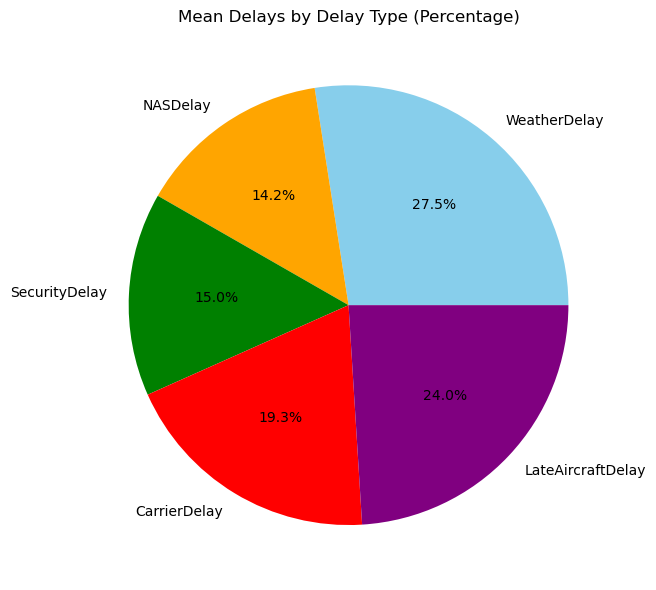

In [219]:
mean_delays = {
    'WeatherDelay': mean_weather_delay,
    'NASDelay': mean_NAS_delay,
    'SecurityDelay': mean_security_delay,
    'CarrierDelay': mean_carrier_delay,
    'LateAircraftDelay': mean_aircraft_delay
}

# Calculate the total mean delay for calculating percentages
total_mean_delay = sum(mean_delays.values())

# Calculate percentages
percentages = [(value / total_mean_delay) * 100 for value in mean_delays.values()]

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(percentages, labels=mean_delays.keys(), autopct='%1.1f%%', colors=['skyblue', 'orange', 'green', 'red', 'purple'])

plt.title('Mean Delays by Delay Type (Percentage)')
plt.tight_layout()
plt.savefig('DelayReason.png', format="png", dpi = 300)

### Predicted data

In [220]:
# Defining variables
delay_reasons = ['WeatherDelay', 'NASDelay', 'SecurityDelay', 'CarrierDelay', 'LateAircraftDelay']

models = {}

# Create an empty dictionary to store the future delays
future_delays = {}

# Looping through each delay reason
for reason in delay_reasons:
    # Filter the DF to include only rows where the delay reason is greater than 0
    filtered_data = df[df[reason] > 0]

    if not filtered_data.empty:
        # Consider 'Year' and 'Month' as features (you can use more relevant features)
        X = filtered_data[['Year', 'Month']].values
        y = filtered_data[reason].values

        # Training the Linear Regression model
        model = LinearRegression()
        model.fit(X, y)
        models[reason] = model

        # Predicting future delays for the current reason
        future_delay = model.predict(future_data)
        
        # Sum the predicted delays for this reason and store in the dictionary
        future_delays[reason] = sum(future_delay)

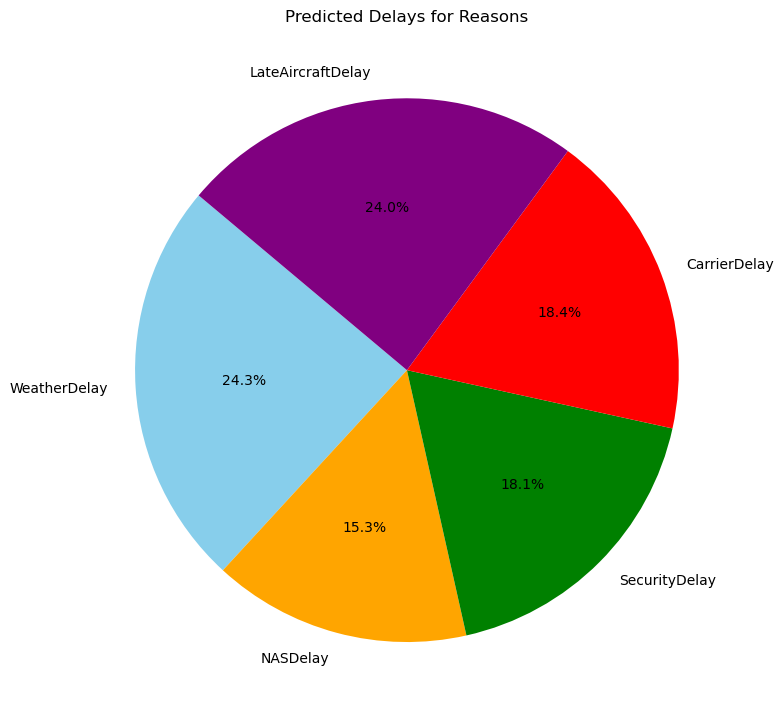

In [221]:
# Create a pie chart to visualize the predicted delays for the reasons where delays actually occurred
plt.figure(figsize = (8, 8))
labels = future_delays.keys()
sizes = future_delays.values()
plt.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 140, colors = ['skyblue', 'orange', 'green', 'red', 'purple'])
plt.title('Predicted Delays for Reasons')
plt.tight_layout()
plt.savefig('PredictedReasonDelay.png', format="png", dpi = 300)

# Flight delay comparison

In [222]:
df['Delayed_Weather'] = (df['WeatherDelay'] > 0).astype(int)
df['Delayed_NAS'] = (df['NASDelay'] > 0).astype(int)
df['Delayed_Security'] = (df['SecurityDelay'] > 0).astype(int)
df['Delayed_Carrier'] = (df['CarrierDelay'] > 0).astype(int)
df['Delayed_LateAircraft'] = (df['LateAircraftDelay'] > 0).astype(int)

features = ['Reporting_Airline']
X = df[features]

# Perform one-hot encoding for the categorical feature 'Reporting_Airline'
encoder = OneHotEncoder(sparse = False)
X_encoded = encoder.fit_transform(X)

# Splitting the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_encoded, df[['Delayed_Weather', 'Delayed_NAS', 'Delayed_Security', 'Delayed_Carrier', 'Delayed_LateAircraft']], test_size=0.2, random_state=42)

# Training Logistic Regression model for each delay reason
models = {}
for reason in ['Weather', 'NAS', 'Security', 'Carrier', 'LateAircraft']:
    model = LogisticRegression(max_iter = 1000)
    model.fit(X_train, y_train[f'Delayed_{reason}'])
    models[reason] = model

/Users/dylanchua/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [223]:
# Create a DF for visualization
viz_df = pd.DataFrame({'Reporting_Airline': X_test[:, 0]})

# Iterate through each delay reason
delay_reasons = ['Weather', 'NAS', 'Security', 'Carrier', 'LateAircraft']
for reason in delay_reasons:
    model = models[reason]
    predicted = model.predict_proba(X_test)[:, 1] * 100  # Convert to percentage
    viz_df[f'Predicted_{reason}'] = predicted

# Group and aggregate data to compare UA and WN
comparison = viz_df.groupby('Reporting_Airline')[[f'Predicted_{reason}' for reason in delay_reasons]].mean()

# Change x-axis labels to UA and WN
comparison.index = ['UA', 'WN']

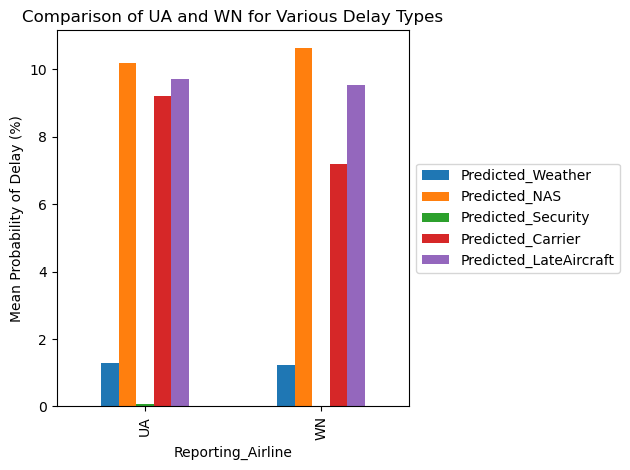

In [224]:
# Plot the comparison
comparison.plot(kind='bar')
plt.xlabel('Reporting_Airline')
plt.ylabel('Mean Probability of Delay (%)')
plt.title('Comparison of UA and WN for Various Delay Types')
plt.legend([f'Predicted_{reason}' for reason in delay_reasons], loc = 'center left', bbox_to_anchor = (1.0, 0.5))
plt.tight_layout()
plt.savefig('UA_WN_Delay.png', format="png", dpi = 300)

# Seasonal predictions

In [225]:
# WN Data
X_wn = wn_df[['Month']].values
y_wn = wn_df['DepDelayMinutes'].values

model_wn = LinearRegression()
model_wn.fit(X_wn, y_wn)

# UA Data
X_ua = ua_df[['Month']].values
y_ua = ua_df['DepDelayMinutes'].values

model_ua = LinearRegression()
model_ua.fit(X_ua, y_ua)

# Define the months to predict for WN and UA
months_to_predict = [[1], [2], [3], [7], [8], [9]]
month_labels = ['Jan', 'Feb', 'Mar', 'Jul', 'Aug', 'Sep']

# Predict DepDelayMinutes for WN and UA for the specified months
predicted_delays_wn = model_wn.predict(months_to_predict)
predicted_delays_ua = model_ua.predict(months_to_predict)

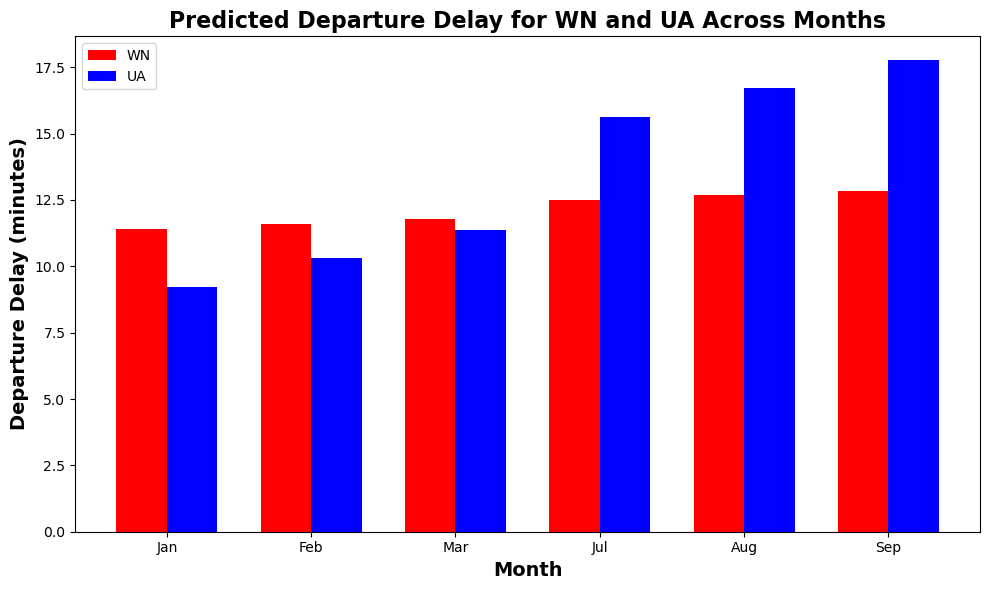

In [226]:
# Plotting data
width = 0.35
x = range(len(month_labels))

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar([i - width / 2 for i in x], predicted_delays_wn, width, label='WN', color='red')
ax.bar([i + width / 2 for i in x], predicted_delays_ua, width, label='UA', color='blue')

ax.set_xlabel('Month', fontsize=14, weight='bold')
ax.set_ylabel('Departure Delay (minutes)', fontsize=14, weight='bold')
ax.set_title('Predicted Departure Delay for WN and UA Across Months', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(month_labels)

ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('UA_WN_Seasonal_Delay.png', format="png", dpi = 300)